In [3]:
pip install statsmodels scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.4 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/9.6 MB 1.4 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/9.6 MB 958.5 kB/s eta 0:00:10
   ---- ----------------------------------- 1.0/9.6 MB 1.1 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.6 MB 1.0 MB/s eta 0:00:09
   ------ --------------------------------- 1.6/9.6 MB 1.1 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.6 MB 1.2 MB/s eta 0:00:07
   -------- ------------------------------- 2.1/9.6 MB 1.2 MB/s eta 0:00:07
   ---------- ----------------------------- 2.6/9.6 MB 1.3 MB/s eta 0:00:06
   ---------- ---------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\devan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Price        Date        Open        High         Low       Close    Volume
Ticker                   GOOG        GOOG        GOOG        GOOG      GOOG
245    2025-10-24  257.299988  262.510010  256.100006  260.510010  18406000
246    2025-10-27  265.359985  270.799988  264.940002  269.929993  22987700
247    2025-10-28  270.200012  271.380005  267.170013  268.429993  20101200
248    2025-10-29  268.609985  275.970001  268.429993  275.170013  25788900
249    2025-10-30  291.869995  291.899994  280.450012  284.229004  37501025
Price        Date       Close
Ticker                   GOOG
0      2024-10-31  171.937485
1      2024-11-01  171.897644
2      2024-11-04  169.936234
3      2024-11-05  170.663071
4      2024-11-06  177.552887


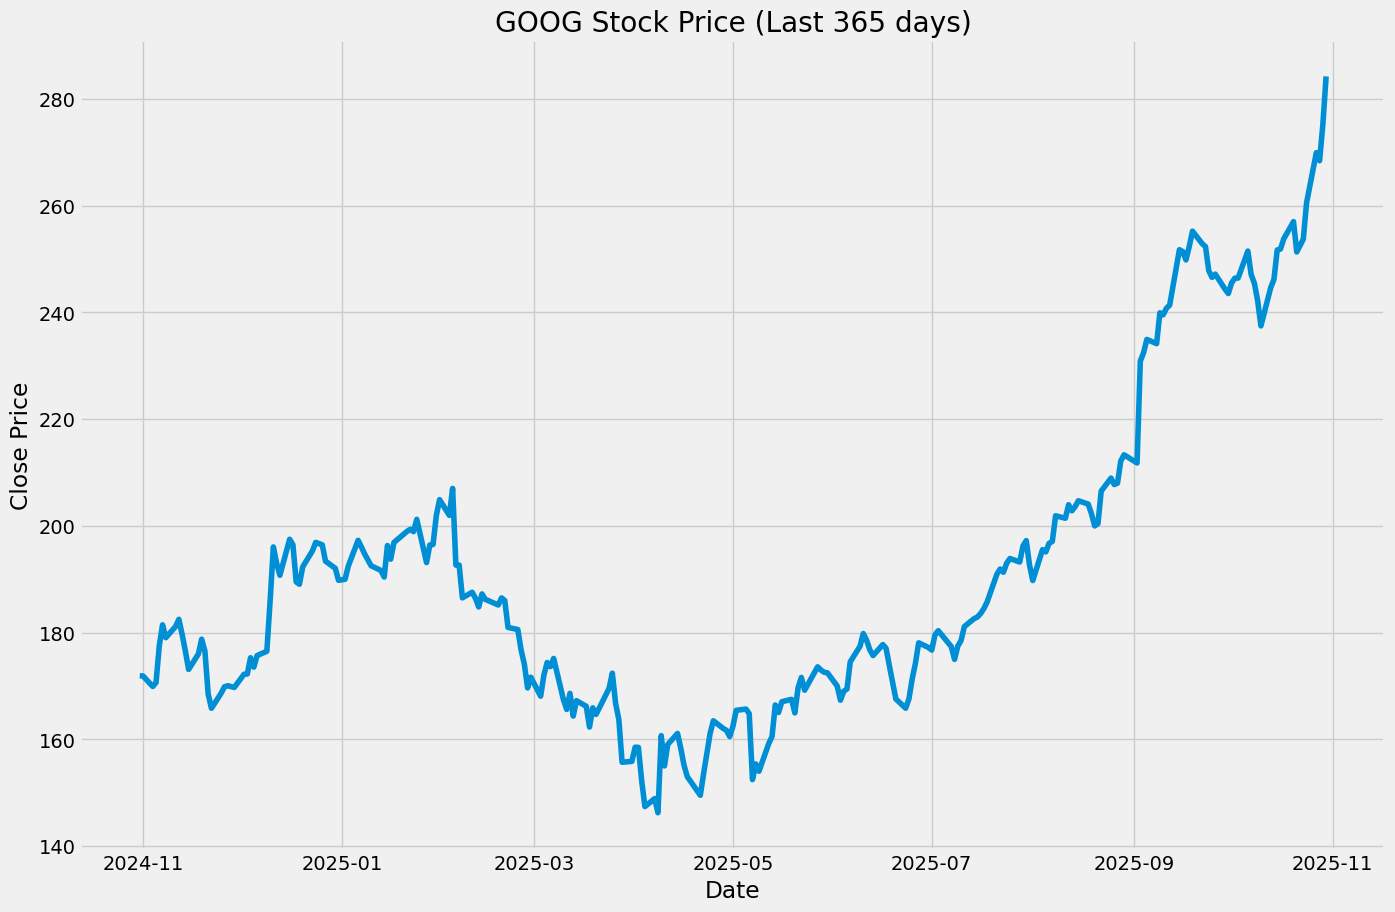

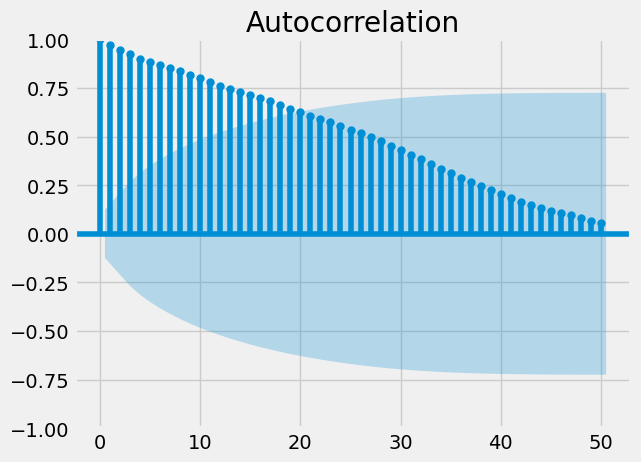

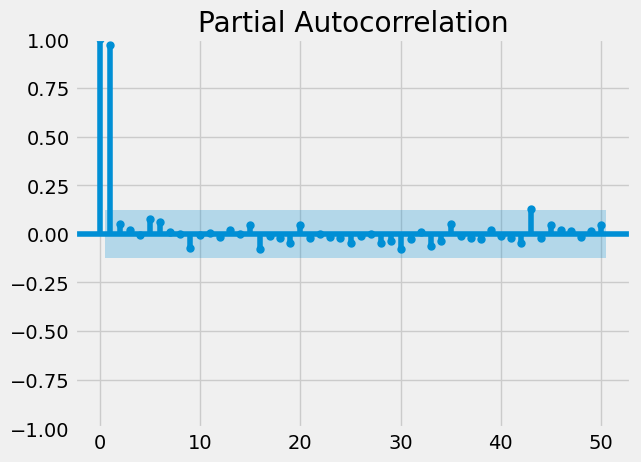

                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                  250
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -684.318
Date:                Fri, 31 Oct 2025   AIC                           1384.635
Time:                        00:22:11   BIC                           1412.775
Sample:                             0   HQIC                          1395.962
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8203      0.080     22.704      0.000       1.663       1.977
ar.L2         -0.9124      0.145     -6.290      0.000      -1.197      -0.628
ar.L3         -0.1411      0.151     -0.936      0.3

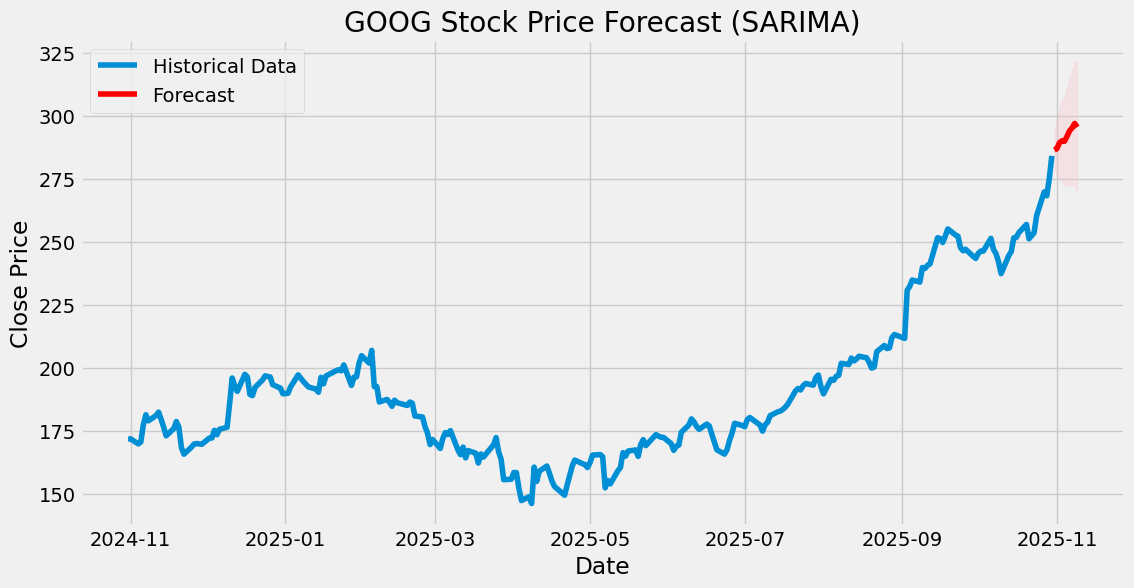

250    286.583141
251    287.116226
252    289.431149
253    290.236434
254    290.066180
255    292.037007
256    294.186692
257    295.374992
258    297.106238
259    295.621730
Name: predicted_mean, dtype: float64


In [1]:


import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Get today's date
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1

# Get the date 365 days ago
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

# Download stock data (GOOG) from Yahoo Finance
data = yf.download('GOOG', start=start_date, end=end_date, progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Print the last few rows of the dataset
print(data.tail())

# Use only Date and Close price columns for analysis
data = data[["Date", "Close"]]
print(data.head())

# Plot the closing price of the stock
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])
plt.title('GOOG Stock Price (Last 365 days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Perform ACF and PACF plots to help identify p, d, q for ARIMA
plot_acf(data["Close"], lags=50)
plot_pacf(data["Close"], lags=50)
plt.show()

# ARIMA Model: p=5, d=1, q=2 (You can adjust these parameters based on ACF/PACF plots)
p, d, q = 5, 1, 2
arima_model = ARIMA(data["Close"], order=(p, d, q))
fitted_arima_model = arima_model.fit()

# Print the summary of the ARIMA model
print(fitted_arima_model.summary())

# SARIMA Model: If you believe the data has seasonal patterns (12 months as a possible seasonal period)
sarima_model = sm.tsa.statespace.SARIMAX(data['Close'],
                                         order=(p, d, q),          # Non-seasonal ARIMA parameters
                                         seasonal_order=(p, d, q, 12))  # Seasonal components (12 months)
fitted_sarima_model = sarima_model.fit()

# Print the summary of the SARIMA model
print(fitted_sarima_model.summary())

# Forecasting using the SARIMA model for the next 10 days (this can be adjusted)
forecast_steps = 10
forecast = fitted_sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Close"], label='Historical Data')
plt.plot(pd.date_range(data["Date"].iloc[-1], periods=forecast_steps + 1, freq='D')[1:], forecast_mean, label='Forecast', color='red')
plt.fill_between(pd.date_range(data["Date"].iloc[-1], periods=forecast_steps + 1, freq='D')[1:], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('GOOG Stock Price Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Print the forecasted values
print(forecast_mean)